In [1]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas
import matplotlib.pyplot as plt
import time
import pickle
from shapely.geometry import Point, Polygon

%matplotlib inline
width = 40
height = 40
plt.rcParams['figure.figsize'] = [width, height]

pd.options.display.max_columns = None

## Set Directory
path = '/data/yoder/DensityProject/'
os.chdir(path)
# os.listdir()

In [2]:
# Load map of US
USMAP = geopandas.read_file(path + '/cb_2018_us_state_500k.shp')

# Read in MTBS Data
MTBS = geopandas.read_file(path + '/mtbs_perimeter_data/mtbs_perims_DD.shp')

## Check CRS
# print(USMAP.crs == MTBS.crs)
# USMAP.crs

# Create set of the 11 Western United States
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

## Plot MTBS data
# basemap = WestStates.plot(color = 'white', edgecolor = 'black')
# MTBS.plot(ax=basemap, color = 'red')

## Prepare to merge with ICS 209
mapcols = WestStates.columns.tolist()
mapcols_to_drop = [col for col in mapcols if col !='geometry']

## Dissolve borders within Western US
WestStates.loc[WestStates['STUSPS'].isin(West), 'Is_west'] = 1
dissolved_west = WestStates.dissolve(by='Is_west')
dissolved_west = dissolved_west.drop(mapcols_to_drop, axis=1).copy()

# Select only fire perimeters entirely within western US
West_MTBS = geopandas.sjoin(MTBS, dissolved_west, op='within')
West_MTBS = West_MTBS.drop(['index_right'], axis = 1)

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [3]:
# Read in 209 Data
ICS_209_inci = pd.read_csv(path + '/ics209-plus-wildfire/ics209-plus-wf_incidents_1999to2014.csv')
# ICS_209_inci.head(2)

# Create GeoDataFrame from ICS data
ICS = geopandas.GeoDataFrame(ICS_209_inci, geometry=geopandas.points_from_xy(ICS_209_inci.POO_LONGITUDE , ICS_209_inci.POO_LATITUDE))

## Assign crs to ICS data
ICS.crs="epsg:4269"

# ICS.crs

# Select ICS forms for 11 Western United States (10319 fires)
WestICS = ICS[ICS['POO_STATE'].isin(West)].copy()

# Creat Dataset with MTBS and ICS
ICBS = pd.merge(West_MTBS, WestICS, left_on='Fire_ID', right_on='MTBS_ID', suffixes =('_from_MTBS','_from_ICS'))
# ICBS.head(2)

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,13,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Project Fires into North American Equal area 2163
ICBS_proj = ICBS.copy()
WestStatesMap_proj = WestStates.to_crs("EPSG:2163")

# Project MTBS perimeters
ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()
ICBS_proj['geometry'] = ICBS_proj['geometry'].to_crs("EPSG:2163")
ICBS_proj['geometry_from_MTBS'] = ICBS_proj['geometry'].copy()

# Project ICS POO perimeter
ICBS_proj['geometry'] = ICBS_proj['geometry_from_ICS'].copy()
ICBS_proj = ICBS_proj.to_crs("EPSG:2163")
ICBS_proj['geometry_from_ICS'] = ICBS_proj['geometry'].copy()

In [5]:
## Select only fires with point of origin within 100 meters of final perimeter

ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()

def get_distance(row):
    distance = row.geometry.distance(row.geometry_from_ICS)
    return distance

ICBS_proj['POO_to_perim'] = ICBS_proj.apply(lambda row: get_distance(row), axis=1)

Fires = ICBS_proj.loc[(ICBS_proj['POO_to_perim'] <= 100)].copy() 
# Fires.POO_to_perim.describe()

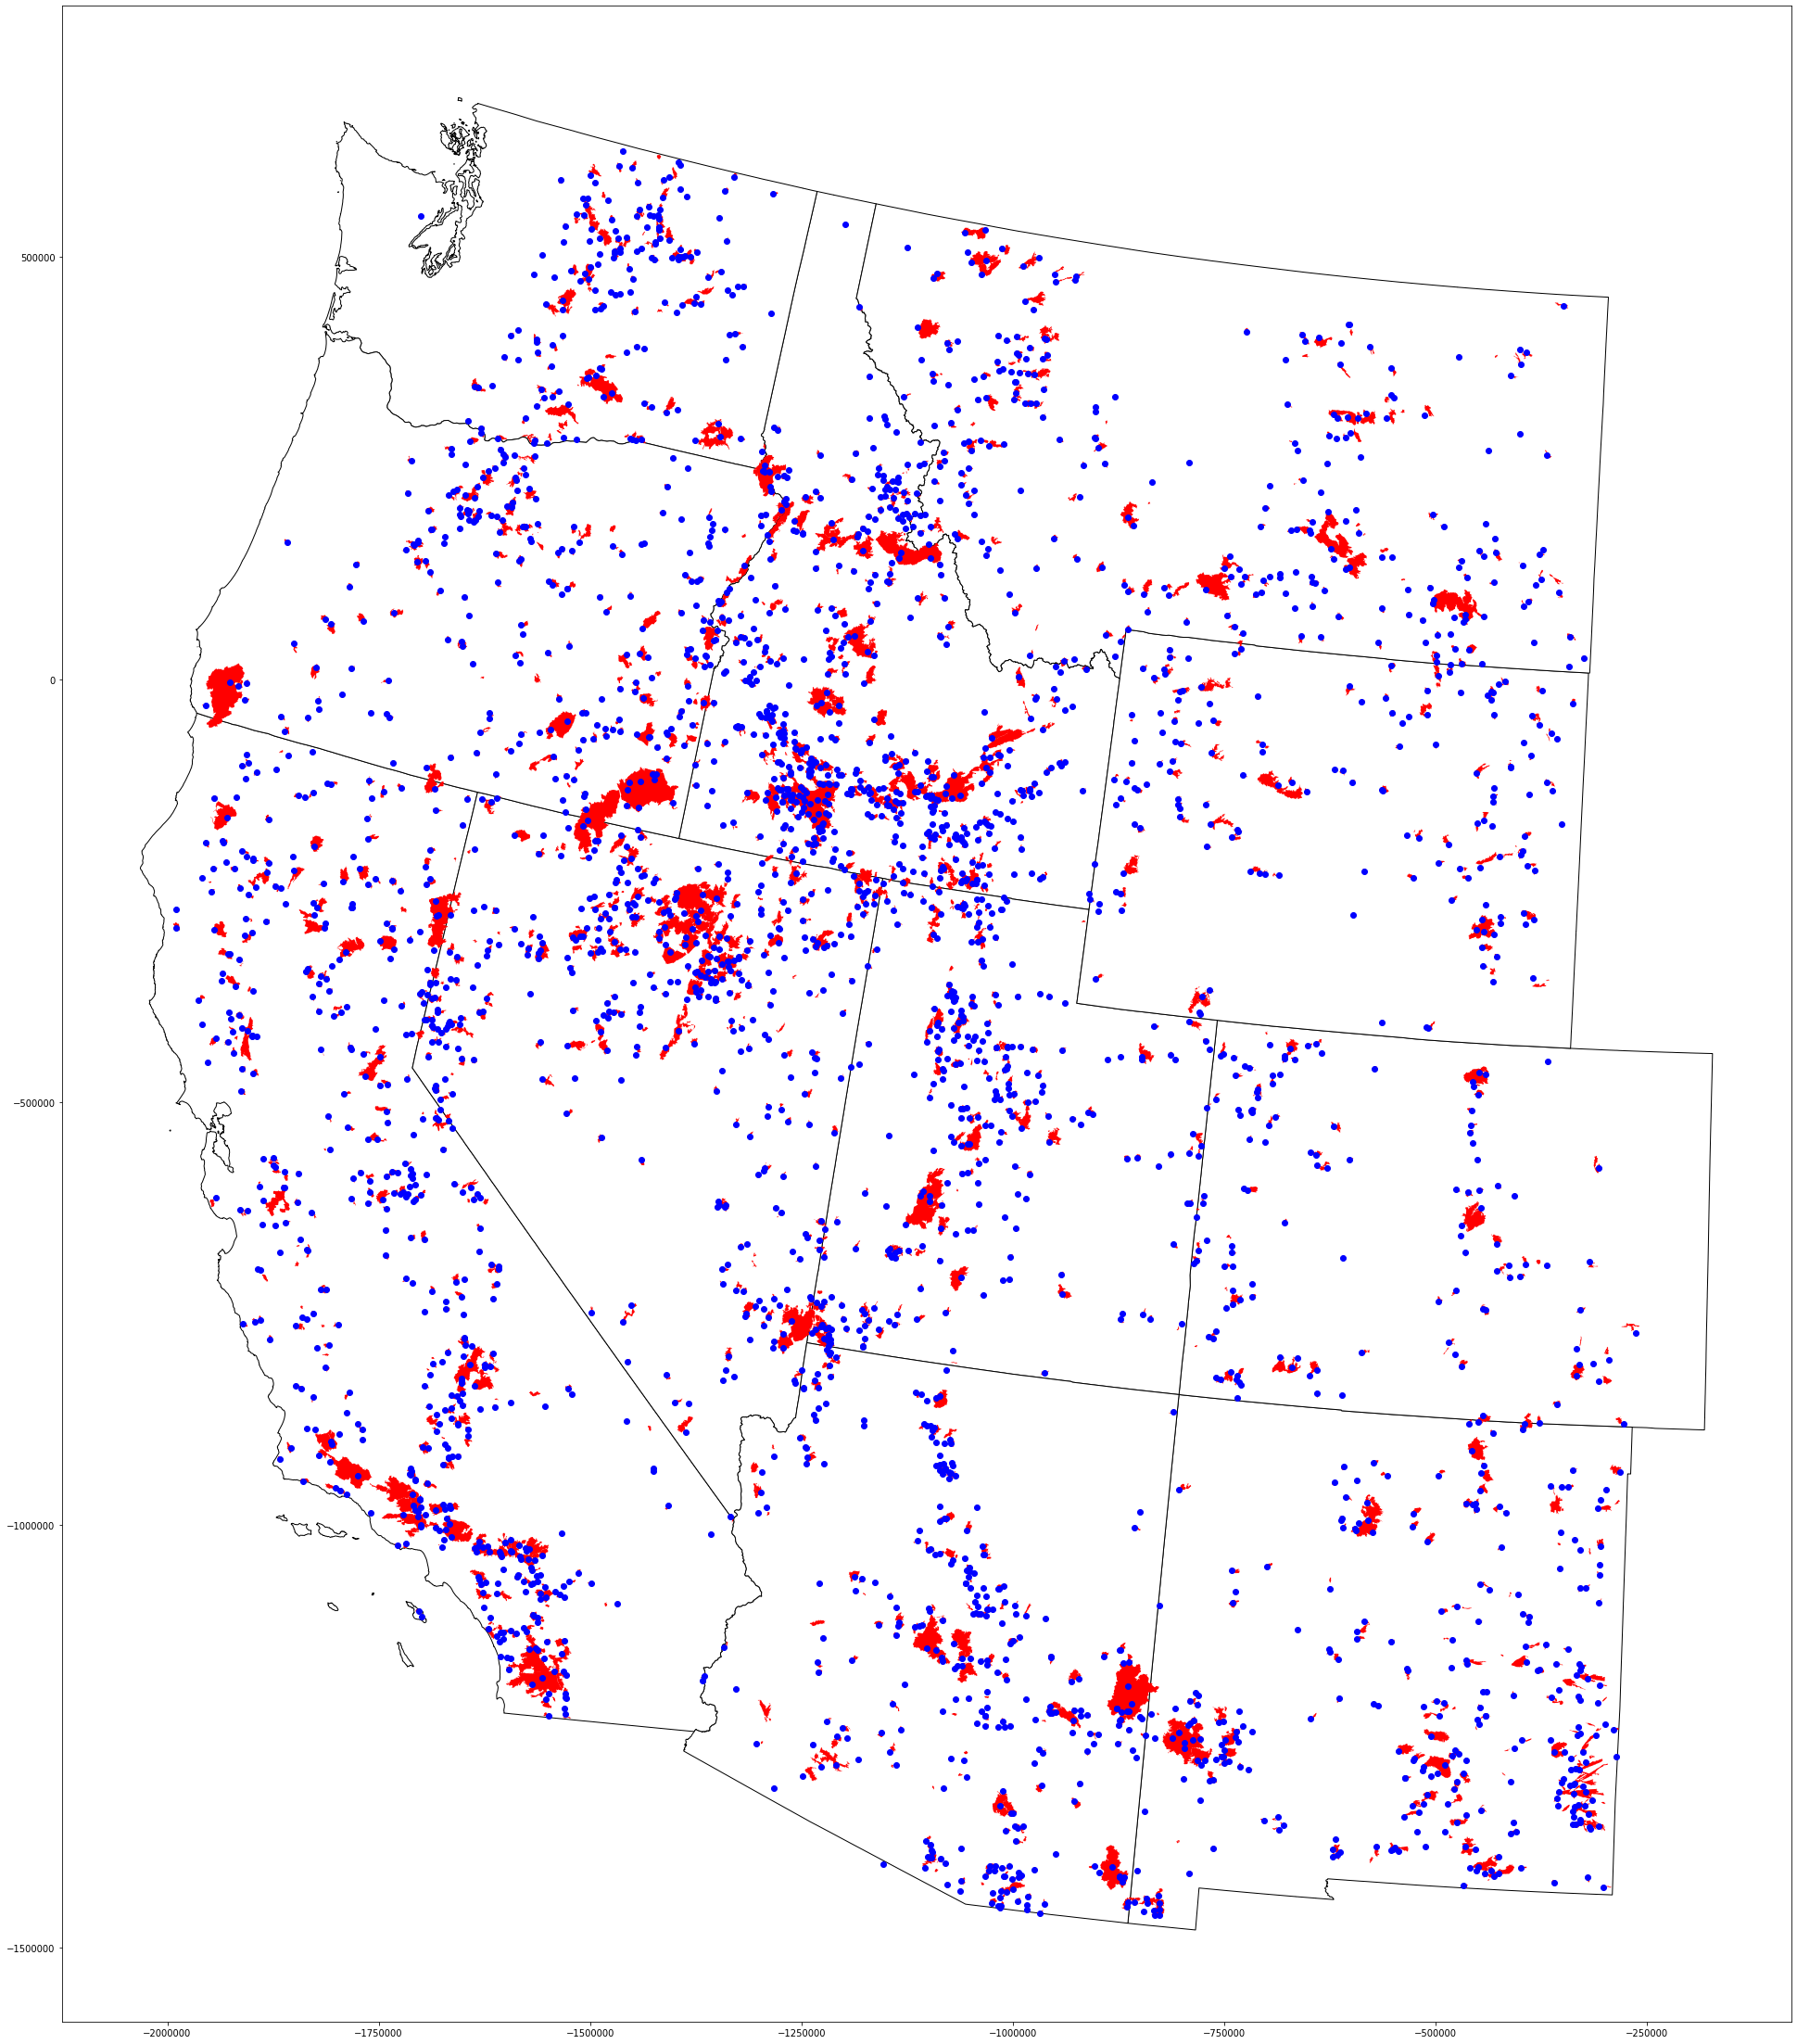

In [42]:
# Plot projected data
basemap = WestStatesMap_proj.plot(edgecolor = 'black', color='white')

ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS']
ICBS_proj.plot(ax=basemap, color = 'red')

ICBS_proj['geometry'] = ICBS_proj['geometry_from_ICS']
ICBS_proj.plot(ax=basemap, color = 'blue')

In [10]:
filepi = open(f'/data/yoder/ZillowAccessor_2001_2014/WithDist/ID_dist','rb')
ID = pickle.load(filepi)

In [12]:
ID['Near'] = np.where(ID['dist_to_perim'] <= 2000, 1,0)

In [13]:
ID = ID[ID.dist_to_perim <=2000]

In [17]:
IDclose = ID[ID.dist_to_origin <=500].copy()

In [44]:
WestStatesMap_proj

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Is_west
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-1357097.048 78008.665, -1356418.733...",1.0
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-1634603.902 627555.336, -1634...",1.0
12,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-862284.832 -1454476.300, -862055.89...",1.0
16,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-1717362.709 -1090134.236, -17...",1.0
21,08,01779779,0400000US08,08,CO,Colorado,00,268422891711,1181621593,"POLYGON ((-786661.937 -668512.657, -785229.222...",1.0
22,49,01455989,0400000US49,49,UT,Utah,00,212886221680,6998824394,"POLYGON ((-1233557.946 -719049.047, -1233307.3...",1.0
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-865796.146 59349.771, -865059.040 5...",1.0
28,32,01779793,0400000US32,32,NV,Nevada,00,284329506470,2047206072,"POLYGON ((-1704711.243 -434243.484, -1704304.7...",1.0
31,30,00767982,0400000US30,30,MT,Montana,00,376962738765,3869208832,"POLYGON ((-1172967.168 508069.445, -1172661.73...",1.0
35,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-1389116.907 -1265584.638, -1388917....",1.0


In [45]:
Idahomap =WestStatesMap_proj[WestStatesMap_proj['STUSPS']=='ID'].copy()

In [53]:
IdahoICBS = ICBS_proj[ICBS_proj['POO_STATE']=='ID'].copy()

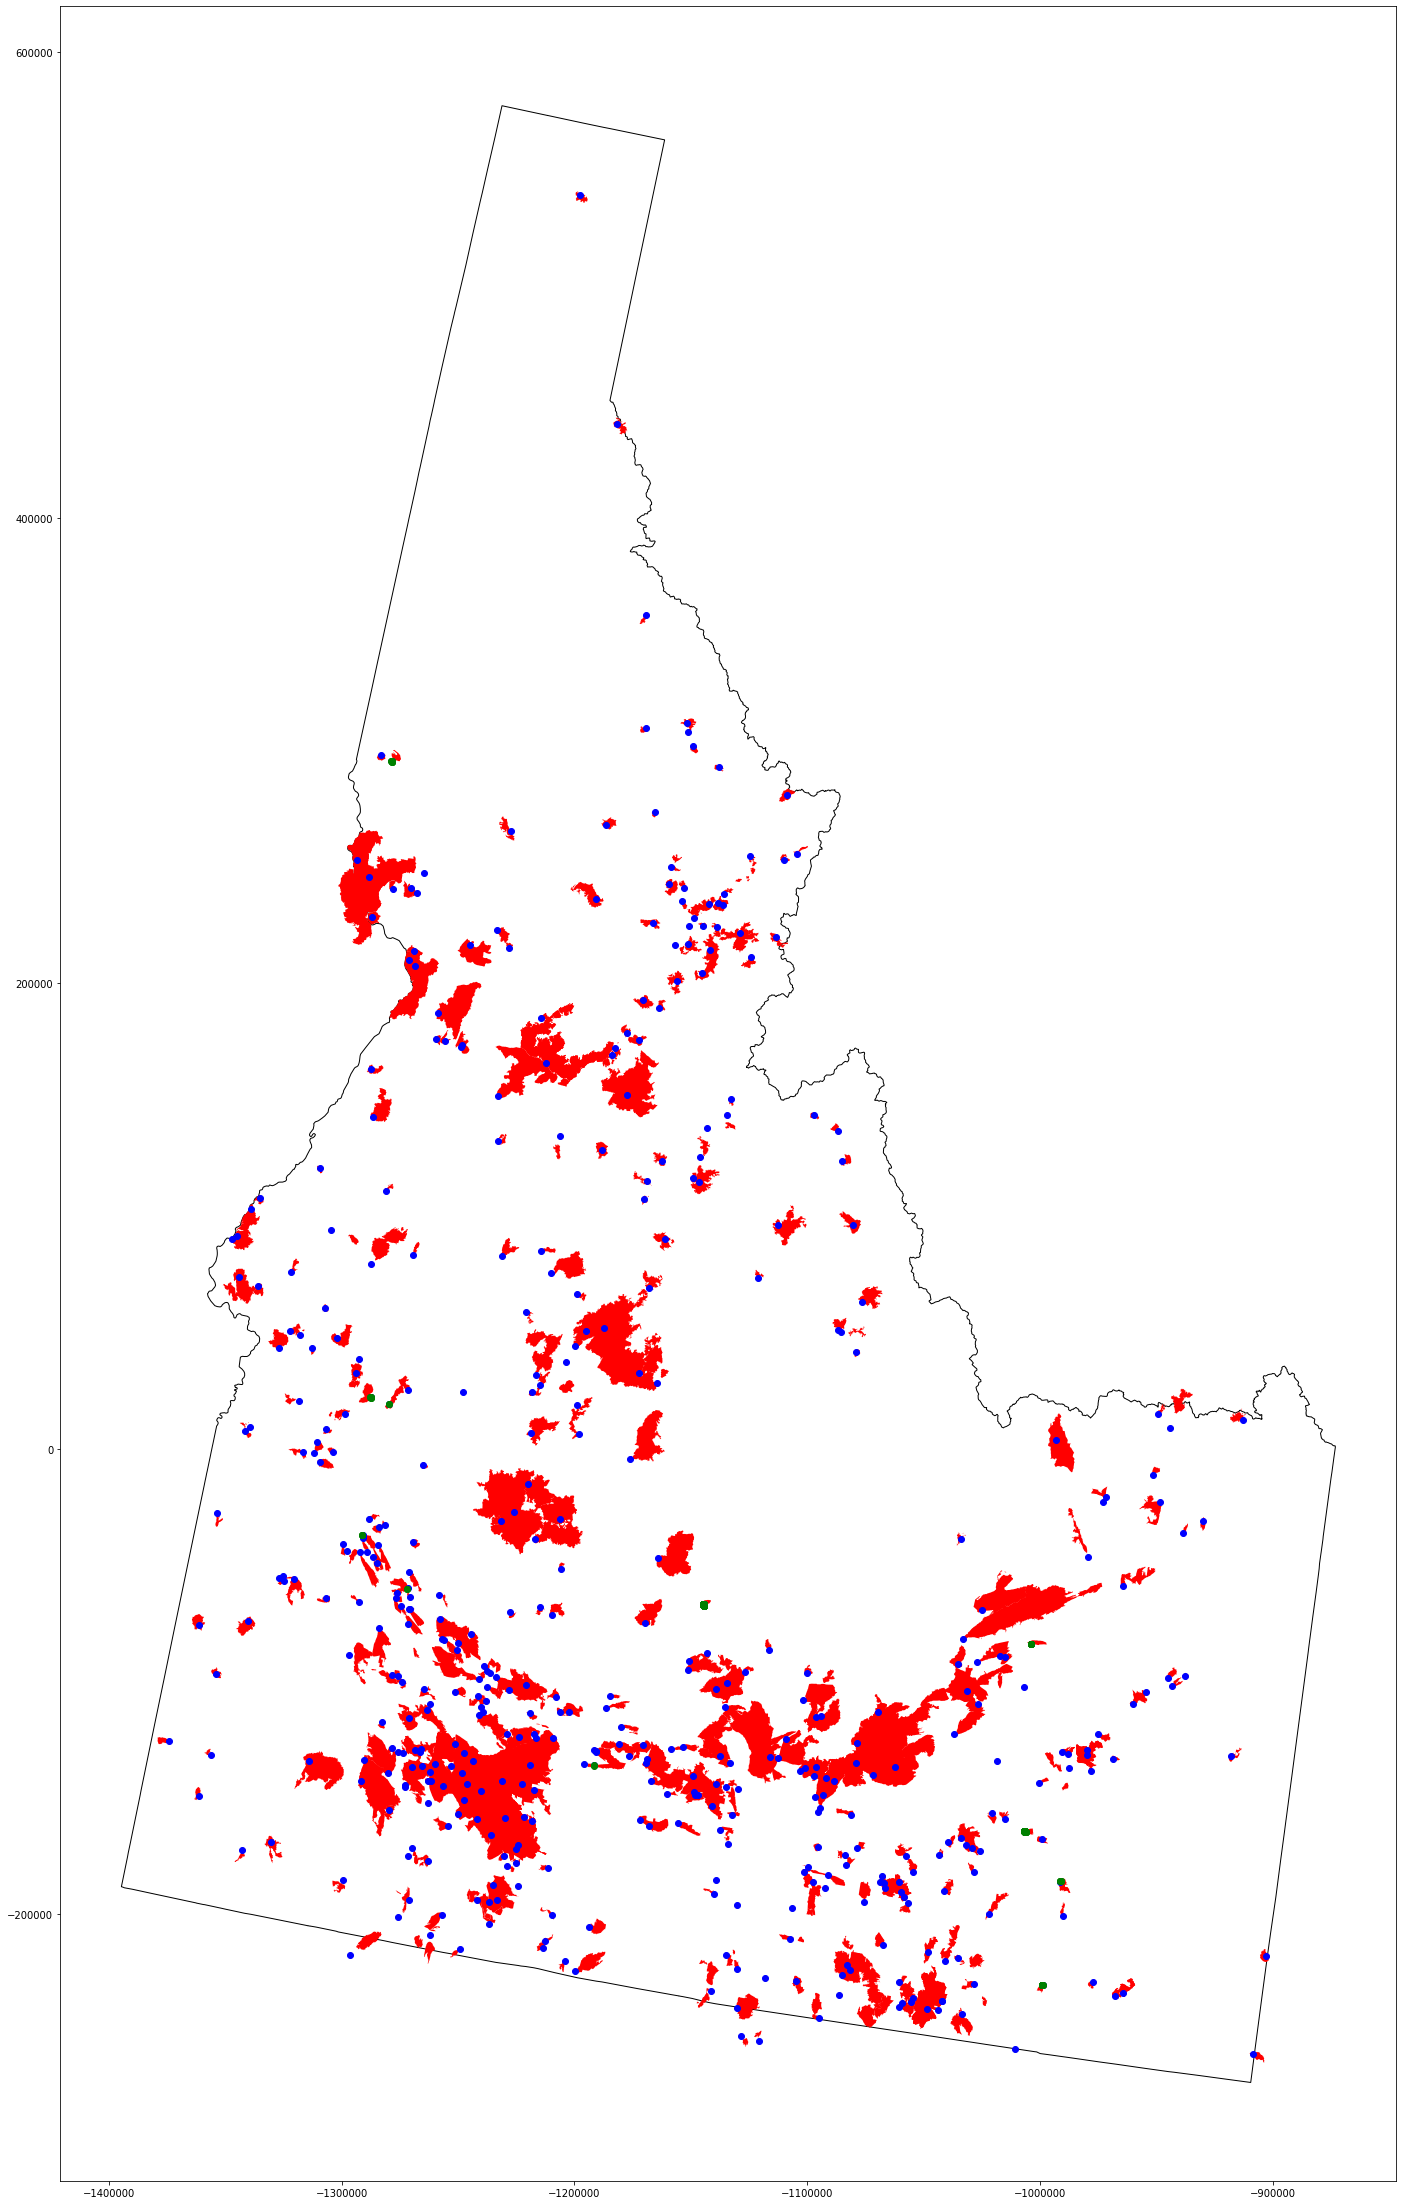

In [55]:
# Plot projected data
basemap = Idahomap.plot(edgecolor = 'black', color='white')

IdahoICBS['geometry'] = IdahoICBS['geometry_from_MTBS']
IdahoICBS.plot(ax=basemap, color = 'red')

IdahoICBS['geometry'] = IdahoICBS['geometry_from_ICS']
IdahoICBS.plot(ax=basemap, color = 'blue')

IDclose.plot(ax=basemap, color='green')

In [56]:
IDclose.columns

Index(['RowID', 'geometry', 'index_right', 'Fire_ID', 'geometry_from_MTBS',
       'geometry_from_ICS', 'dist_to_origin', 'dist_to_perim', 'Near'],
      dtype='object')

In [64]:
IDclose.groupby(['Fire_ID']).describe()

index_right                                       \
                            count    mean  std     min     25%     50%   
Fire_ID                                                                  
ID4225911218820121020        14.0   928.0  0.0   928.0   928.0   928.0   
ID4265211214920030721         6.0  1001.0  0.0  1001.0  1001.0  1001.0   
ID4280911470420110901         2.0  1042.0  0.0  1042.0  1042.0  1042.0   
ID4283111240020110815       265.0  1046.0  0.0  1046.0  1046.0  1046.0   
ID4334511584620140801         2.0  1167.0  0.0  1167.0  1167.0  1167.0   
ID4349411609420020713         3.0  1189.0  0.0  1189.0  1189.0  1189.0   
ID4350511426320020818       821.0  1191.0  0.0  1191.0  1191.0  1191.0   
ID4356011248420030719         7.0  1200.0  0.0  1200.0  1200.0  1200.0   
ID4403611624020140810         6.0  1224.0  0.0  1224.0  1224.0  1224.0   
ID4403811612320070903         2.0  1225.0  0.0  1225.0  1225.0  1225.0   
ID4646611682120070713         7.0  1363.0  0.0  1363.0  1363.0  1363.0   

                                      dist_to_origin                          \
                          75%     max          count        mean         std   
Fire_ID                                                                        
ID4225911218820121020   928.0   928.0           14.0  392.644373  139.057772   
ID4265211214920030721  1001.0  1001.0            6.0  464.025733   22.118046   
ID4280911470420110901  1042.0  1042.0            2.0  180.154647  165.535693   
ID4283111240020110815  1046.0  1046.0          265.0  227.859915  141.756940   
ID4334511584620140801  1167.0  1167.0            2.0  398.379905    0.000000   
ID4349411609420020713  1189.0  1189.0            3.0  276.094673    0.000000   
ID4350511426320020818  1191.0  1191.0          821.0  386.174271   87.516879   
ID4356011248420030719  1200.0  1200.0            7.0  230.955891   78.523293   
ID4403611624020140810  1224.0  1224.0            6.0  367.590627   78.718604   
ID4403811612320070903  1225.0  1225.0            2.0  217.658577    0.000000   
ID4646611682120070713  1363.0  1363.0            7.0  317.649709  113.228086   

                                                                       \
                              min         25%         50%         75%   
Fire_ID                                                                 
ID4225911218820121020   64.414162  447.349408  447.349408  447.349408   
ID4265211214920030721  439.359134  446.811082  469.166927  469.166927   
ID4280911470420110901   63.103236  121.628941  180.154647  238.680352   
ID4283111240020110815   32.689385  118.575427  164.770642  338.942561   
ID4334511584620140801  398.379905  398.379905  398.379905  398.379905   
ID4349411609420020713  276.094673  276.094673  276.094673  276.094673   
ID4350511426320020818  153.029029  324.727400  407.355416  460.418092   
ID4356011248420030719  184.977359  184.977359  184.977359  265.439791   
ID4403611624020140810  275.898215  300.959286  376.142499  424.638027   
ID4403811612320070903  217.658577  217.658577  217.658577  217.658577   
ID4646611682120070713  148.570137  254.206388  371.511773  391.641262   

                                  dist_to_perim                          \
                              max         count        mean         std   
Fire_ID                                                                   
ID4225911218820121020  447.349408          14.0    2.553830    6.491722   
ID4265211214920030721  497.935347           6.0    0.000000    0.000000   
ID4280911470420110901  297.206058           2.0  126.143339  107.637594   
ID4283111240020110815  499.802489         265.0  165.991778   98.824440   
ID4334511584620140801  398.379905           2.0    0.000000    0.000000   
ID4349411609420020713  276.094673           3.0  241.295243    0.000000   
ID4350511426320020818  499.898501         821.0  230.169342   85.521530   
ID4356011248420030719  345.902222           7.0   13.417060    2.481988   
ID44036116240201

In [112]:
SampleFire= IDclose.groupby(['Fire_ID']).get_group('ID4283111240020110815')

In [113]:
SampleFire['struc_geometry'] = SampleFire['geometry'].copy()

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Firesgeo40km = Fires[['Fire_ID','geometry_from_MTBS','geometry_from_ICS','geometry']].copy()
Firesgeo40km['geometry'] = Firesgeo40km['geometry_from_ICS']
Firesgeo40km['geometry'] = Firesgeo40km.buffer(40000)

In [115]:
SampleFireBuff = SampleFire.copy()

In [116]:
SampleFireBuff['geometry'] = SampleFireBuff['geometry_from_MTBS']
SampleFireBuff['geometry'] = SampleFireBuff.buffer(500)

Index(['RowID', 'geometry', 'index_right', 'Fire_ID', 'geometry_from_MTBS',
       'geometry_from_ICS', 'dist_to_origin', 'dist_to_perim', 'Near',
       'struc_geometry'],
      dtype='object')

In [118]:
SampleFire = SampleFire.drop_duplicates(['geometry'], keep='first')

In [120]:
SampleFire

,RowID,geometry,index_right,Fire_ID,geometry_from_MTBS,geometry_from_ICS,dist_to_origin,dist_to_perim,Near,struc_geometry
29015,DE9A089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006516.244 -164516.369),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),32.689385,87.655721,1,POINT (-1006516.244 -164516.369)
29034,FA9A089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006449.053 -164616.916),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),88.256970,108.143600,1,POINT (-1006449.053 -164616.916)
30374,EC9C089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006452.353 -164638.968),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),105.946134,122.668009,1,POINT (-1006452.353 -164638.968)
37515,4BA0089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006404.501 -164319.221),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),242.346839,50.752380,1,POINT (-1006404.501 -164319.221)
37526,4DA0089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006454.003 -164649.993),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),115.391068,128.319361,1,POINT (-1006454.003 -164649.993)
37529,50A0089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006455.653 -164661.019),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),125.116721,133.970710,1,POINT (-1006455.653 -164661.019)
37530,51A0089C-50D5-E511-80C1-3863BB43AC67,POINT (-1006378.560 -164695.411),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),193.201938,75.318062,1,POINT (-1006378.560 -164695.411)
154528,27F20D9E-50D5-E511-80C1-3863BB43AC67,POINT (-1006451.885 -164086.366),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),458.959012,283.678374,1,POINT (-1006451.885 -164086.366)
161396,53F40D9E-50D5-E511-80C1-3863BB43AC67,POINT (-1006528.970 -164051.973),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),492.106619,344.663144,1,POINT (-1006528.970 -164051.973)
161397,54F40D9E-50D5-E511-80C1-3863BB43AC67,POINT (-1006542.173 -164140.179),1046,ID4283111240020110815,"POLYGON ((-1002915.167 -164910.836, -1002906.3...",POINT (-1006497.377 -164543.065),405.368468,275.088462,1,POINT (-1006542.173 -164140.179)


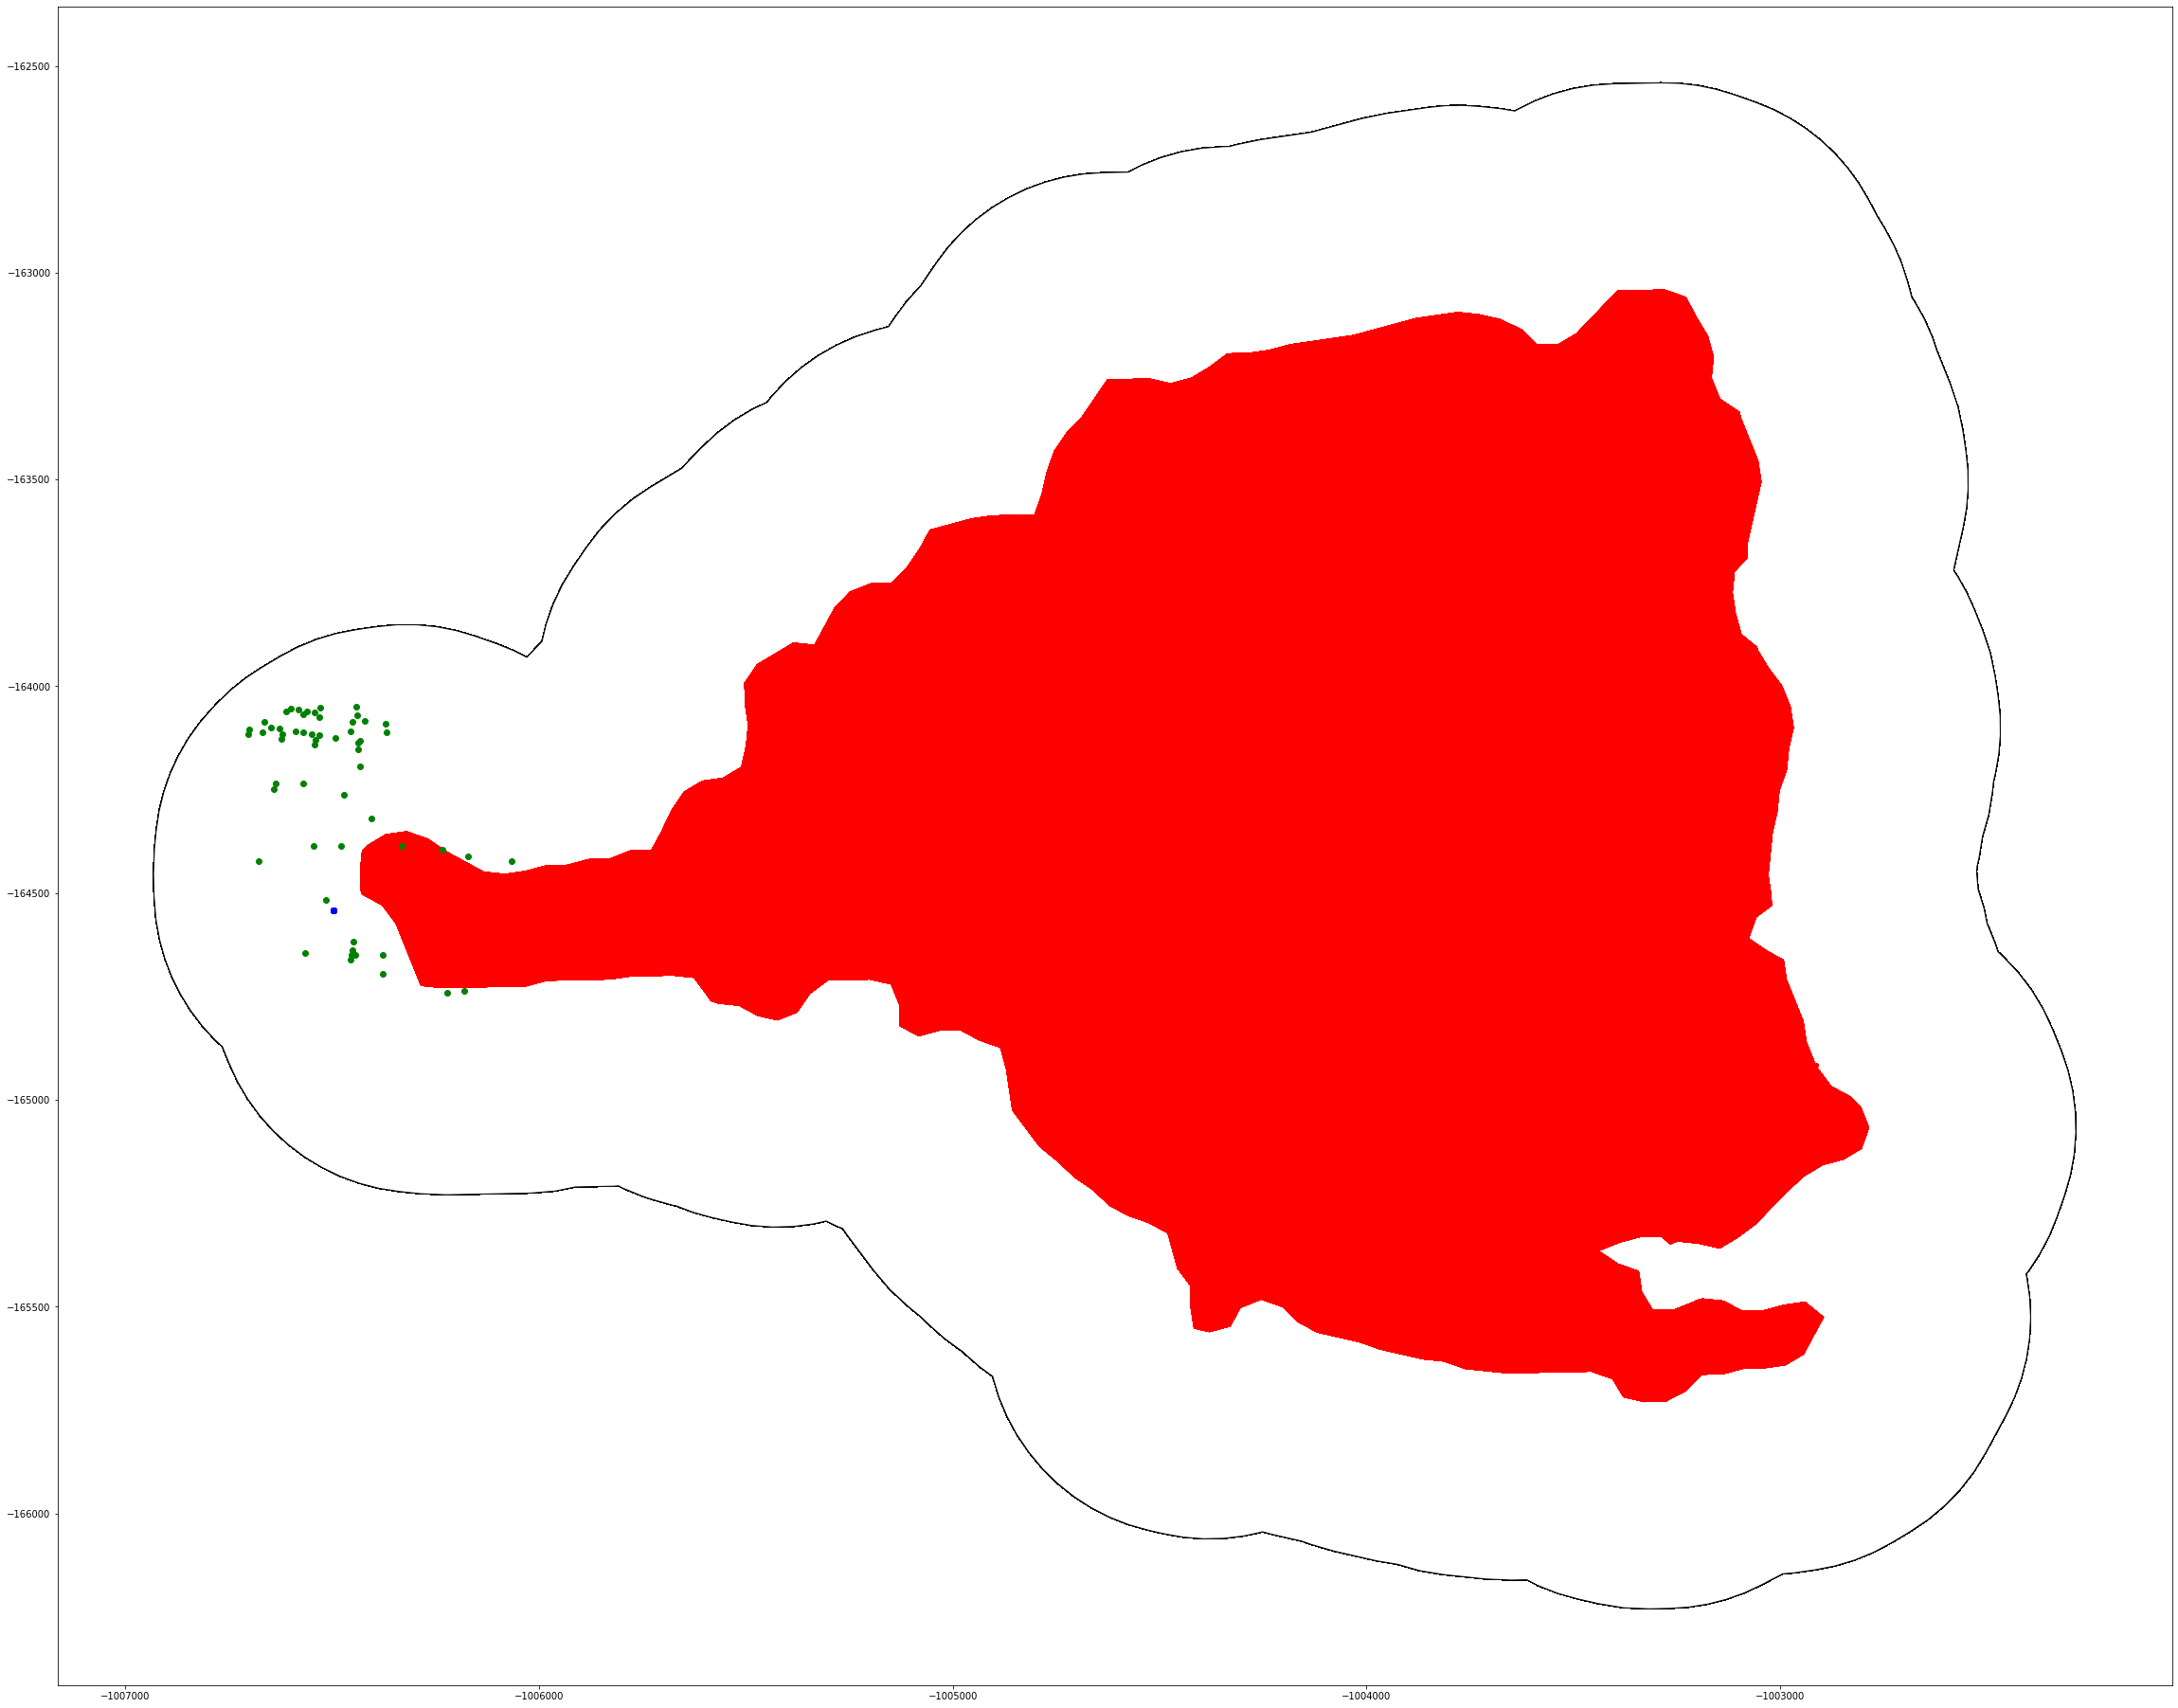

In [121]:
# Plot projected data

basemap = SampleFireBuff.plot(edgecolor = 'black', color='white')

SampleFire['geometry'] = SampleFire['geometry_from_MTBS']
SampleFire.plot(ax=basemap, color = 'red')

SampleFire['geometry'] = SampleFire['geometry_from_ICS']
SampleFire.plot(ax=basemap, color = 'blue')

SampleFire['geometry'] = SampleFire['struc_geometry']
SampleFire.plot(ax=basemap, color = 'green')

In [176]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


In [177]:
bp = rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif')

In [143]:
bp = rioxarray.open_rasterio('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif')

In [183]:
ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS']


In [178]:
SampleFire.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [180]:
bp.crs

CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [181]:
with rio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as bp:
    bp_extent = plotting_extent(bp)

In [185]:
with rio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as bp_src:
    probdata = bp_src.read()
    
    ICBS_proj = ICBS_proj.to_crs(bp_src.crs)
    
    bp_plot_extent = plotting_extent(bp_src)

AttributeError: 'AxesImage' object has no property 'rgb'

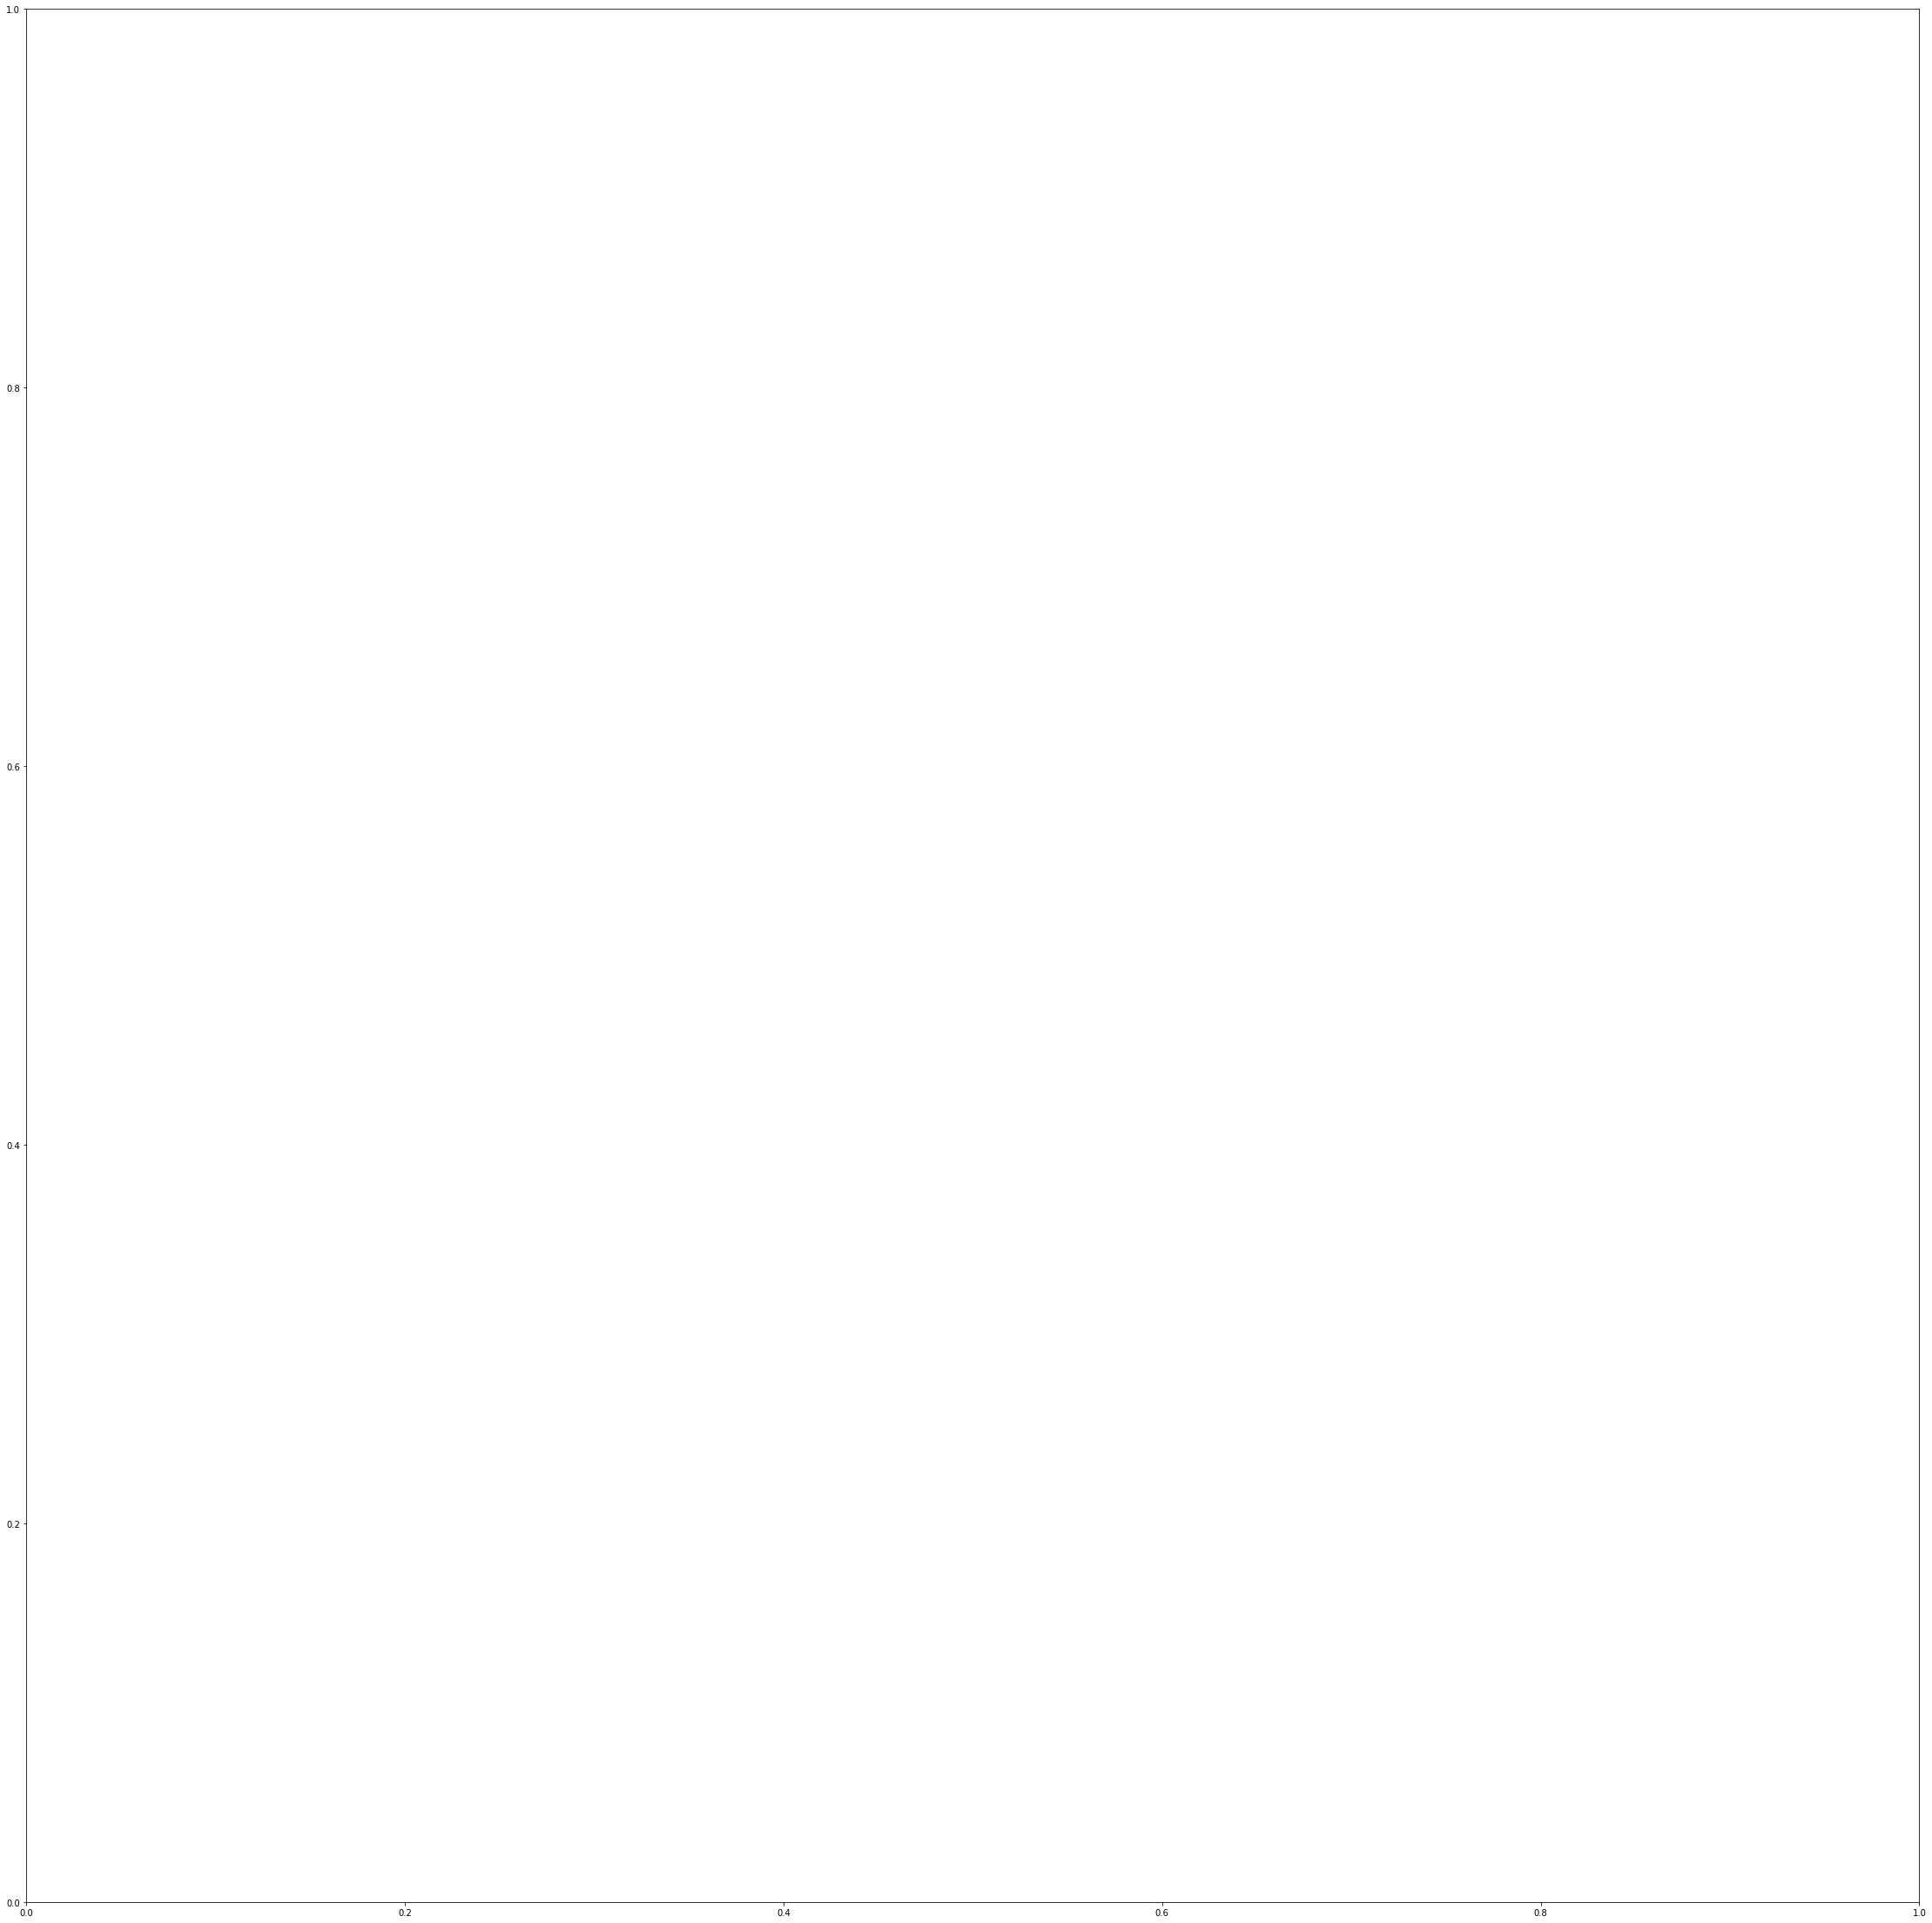

In [203]:
# Plot uncropped array
f, ax = plt.subplots()

show(probdata,
            rgb=[0, 1, 2],
            ax=ax,
            title="Fire boundary overlayed on top of uncropped NAIP data",
            extent=bp_plot_extent)  # Use plotting extent from DatasetReader object

# ICBS_proj.plot(ax=ax)

plt.show()

In [ ]:
f, ax = plt.subplots()



(-2361825.000000001, 2264084.999999999, 258794.99999999814, 3175604.999999998)

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/matplotlib/image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


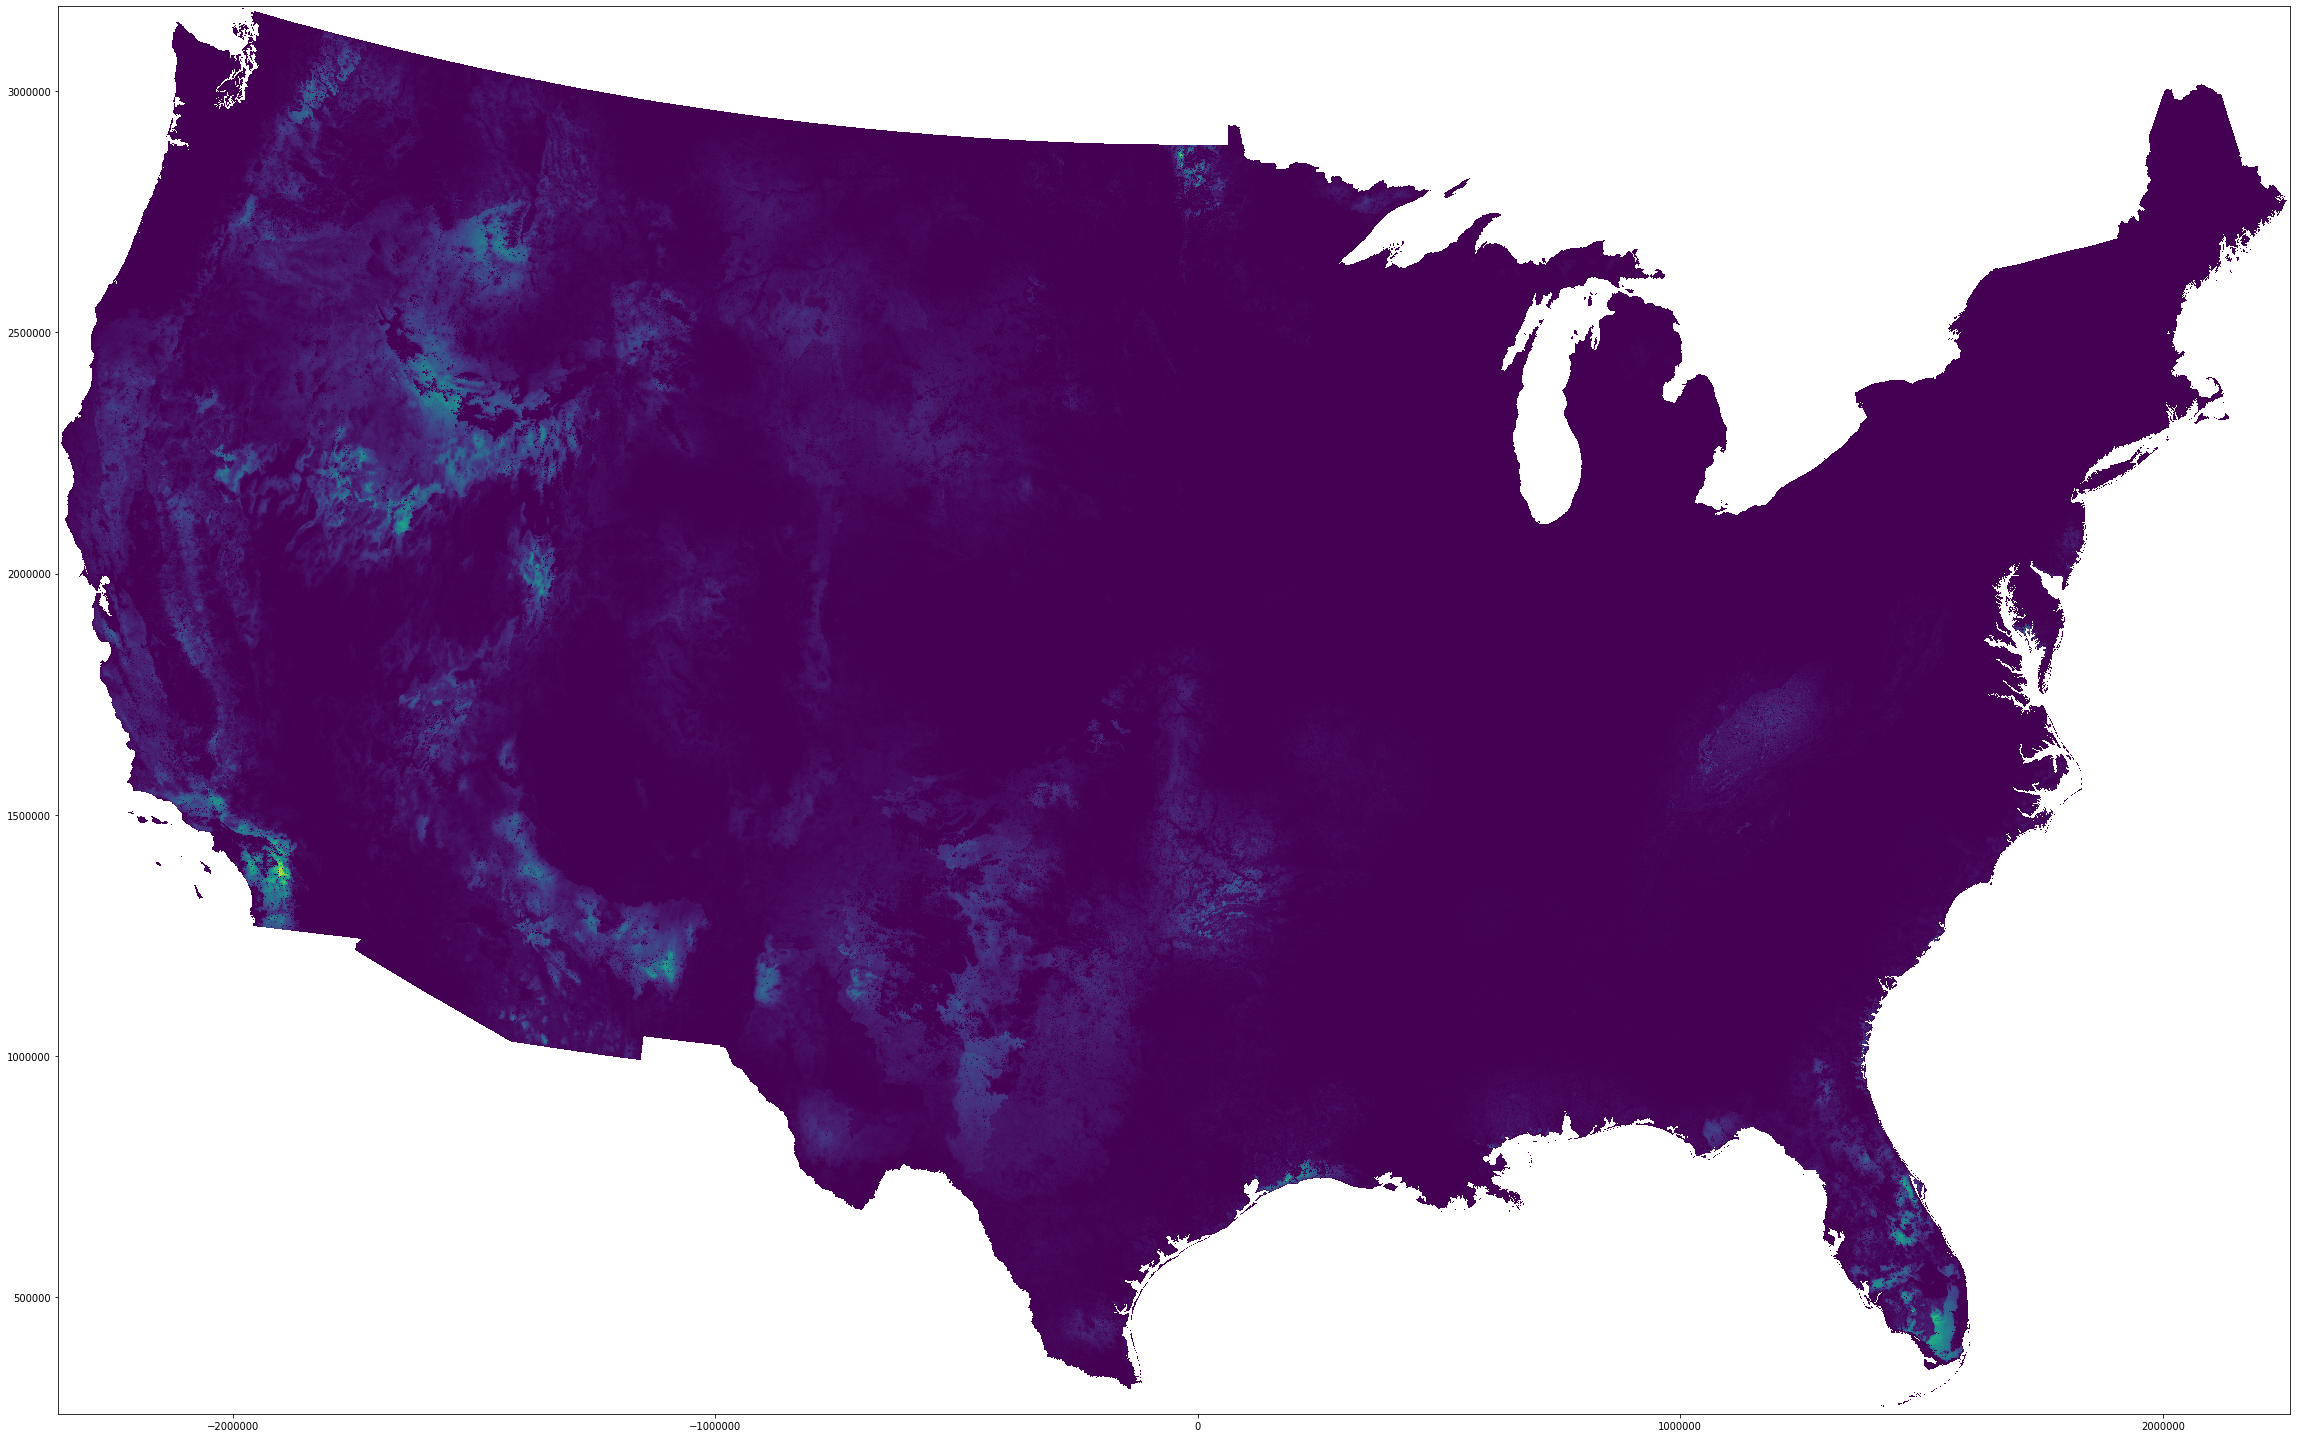

In [163]:
show(bp)

In [160]:
bp.plot()

AttributeError: 'DatasetReader' object has no attribute 'plot'

In [155]:
dst_crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [151]:
dst_crs = SampleFire.crs

In [ ]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)